# Chapter 12
## Leveraging similarity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import confusion_matrix, calinski_harabasz_score, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_circles, make_blobs

In [2]:
penguins = pd.read_feather("../datasets/penguins.feather")
le = LabelEncoder()

features = penguins.iloc[:,1:5]
labels = le.fit_transform(penguins.species)
target_names = dict(zip(range(3), le.classes_))

print(target_names)

{0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}


## K-means

Explained variance:
[2.75362487 0.7804609  0.36975289 0.10820954] 


Adelie          [[124   0  22]
Chinstrap        [  5   0  63]
Gentoo           [  0 119   0]]


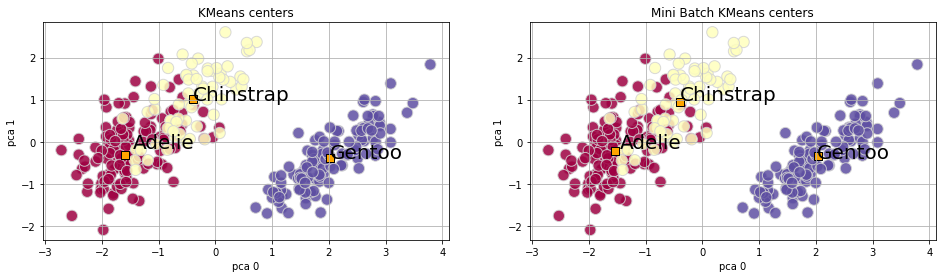

In [3]:
pca = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])

k_means = KMeans(n_clusters=3, init='k-means++', max_iter=999, n_init=10, random_state=101)
mb_k_means = MiniBatchKMeans(n_clusters=3, init='k-means++', max_iter=999, batch_size=30, n_init=10, random_state=101)

pca_features = pca.fit_transform(features)

print('Explained variance:')
print(pca.named_steps['pca'].explained_variance_, '\n\n')

k_means.fit(pca_features)
mb_k_means.fit(pca_features)

cm = str(confusion_matrix(y_true=labels, y_pred=k_means.labels_)).split('\n')
[print(f"{target_names[i]:15} {cm[i]}") for i in range(3)]

km_centers = k_means.cluster_centers_
mbkm_centers = mb_k_means.cluster_centers_

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.scatter(pca_features[:,0], pca_features[:,1], s=128, c=labels, edgecolors='lightgray', alpha=0.85, cmap='Spectral')
ax1.set_xlabel('pca 0')
ax1.set_ylabel('pca 1')
ax1.set_title('KMeans centers')
ax1.scatter(km_centers[:,0], km_centers[:,1], s=64, marker='s', c='orange', edgecolors='black')
ax1.grid()

for i in range(3):
    ax1.annotate(target_names[i], (pca_features[labels==i, 0].mean(),
                                   pca_features[labels==i, 1].mean()), fontsize=20)

ax2.scatter(pca_features[:,0], pca_features[:,1], s=128, c=labels, edgecolors='lightgray', alpha=0.85, cmap='Spectral')
ax2.set_xlabel('pca 0')
ax2.set_ylabel('pca 1')
ax2.set_title('Mini Batch KMeans centers')
ax2.scatter(mbkm_centers[:,0], mbkm_centers[:,1], s=64, marker='s', c='orange', edgecolors='black')
ax2.grid()

for i in range(3):
    ax2.annotate(target_names[i], (pca_features[labels==i, 0].mean(),
                                   pca_features[labels==i, 1].mean()), fontsize=20)

plt.show()

In [4]:
np.set_printoptions(precision=3, suppress=True)

for i in range(1, 10):
    k_means = KMeans(n_clusters=3, init='random', max_iter=i, n_init=1, random_state=0)
    k_means.fit(pca_features)
    
    print('Iteration: {} - 2st centroid: {}'.format(i, k_means.cluster_centers_[0]))

Iteration: 1 - 2st centroid: [-0.882  0.208  0.03   0.025]
Iteration: 2 - 2st centroid: [-0.795  0.631  0.036  0.018]
Iteration: 3 - 2st centroid: [-0.65   0.814  0.07   0.012]
Iteration: 4 - 2st centroid: [-0.539  0.905  0.188 -0.011]
Iteration: 5 - 2st centroid: [-0.445  0.971  0.285 -0.039]
Iteration: 6 - 2st centroid: [-0.408  0.992  0.351 -0.036]
Iteration: 7 - 2st centroid: [-0.398  1.004  0.376 -0.035]
Iteration: 8 - 2st centroid: [-0.394  1.013  0.384 -0.03 ]
Iteration: 9 - 2st centroid: [-0.394  1.013  0.384 -0.03 ]


### Evaluating

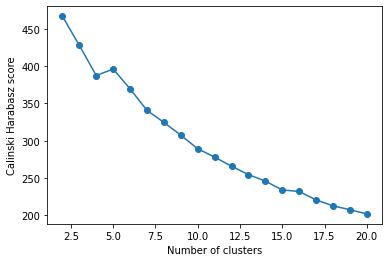

In [5]:
ch_scores = []
max_clus = 20

for clus in range(2, max_clus+1):
    k_means = KMeans(n_clusters=clus, init='k-means++', max_iter=999, n_init=10, random_state=101)
    k_means.fit(pca_features)
    ch = calinski_harabasz_score(pca_features, k_means.labels_)
    ch_scores.append(ch)

plt.plot(range(2, max_clus+1), ch_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski Harabasz score')

plt.show()

Adelie          [[84  0 60  2  0]
Chinstrap        [ 5  0  0 63  0]
Gentoo           [ 0 57  0  0 62]



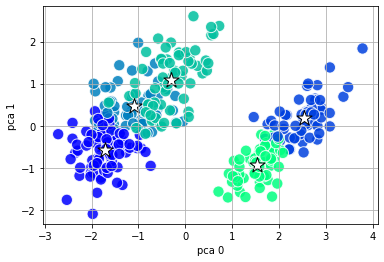

In [6]:
k_means = KMeans(n_clusters=5, init='k-means++', max_iter=999, n_init=10, random_state=101)
k_means.fit(pca_features)

km_centers = k_means.cluster_centers_

cm = str(confusion_matrix(y_true=labels, y_pred=k_means.labels_)).split('\n')
[print(f"{target_names[i]:15} {cm[i]}") for i in range(3)]
print()

plt.scatter(pca_features[:,0], pca_features[:,1], s=128, c=k_means.labels_, edgecolors='white', alpha=0.85, cmap='winter')
plt.scatter(km_centers[:,0], km_centers[:,1], s=256, marker='*', c='white', edgecolors='black')
plt.xlabel('pca 0')
plt.ylabel('pca 1')
plt.grid()

plt.show()

## K-Nearest Neighbors

In [7]:
knn = KNeighborsClassifier(metric='euclidean')
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
param_grid = {"n_neighbors": range(1, 16)}

experiment = GridSearchCV(knn, param_grid=param_grid, cv=kfold)

In [8]:
experiment.fit(features, labels)

print(f"Best params: {experiment.best_params_}")
print(f"best cv accuracy: {experiment.best_score_:0.3}")

Best params: {'n_neighbors': 1}
best cv accuracy: 0.859


In [9]:
experiment.fit(pca_features, labels)

print(f"Best params: {experiment.best_params_}")
print(f"best cv accuracy: {experiment.best_score_:0.3}")

Best params: {'n_neighbors': 3}
best cv accuracy: 0.991


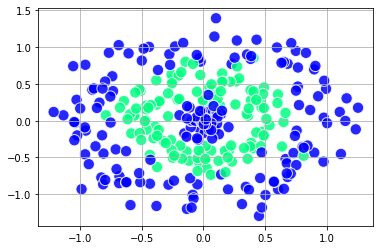

In [10]:
strange_data = make_circles(n_samples=500, shuffle=True, noise=0.15, random_state=101, factor=0.5)
center = make_blobs(n_samples=100, n_features=2, centers=1, cluster_std=0.1, center_box=(0, 0))

first_half = np.row_stack((strange_data[0][:250,:], center[0][:50,:]))
first_labels = np.append(strange_data[1][:250], np.zeros(50))
second_half = np.row_stack((strange_data[0][250:,:], center[0][50:,:]))
second_labels = np.append(strange_data[1][250:], np.zeros(50))

plt.scatter(first_half[:,0], first_half[:,1], s=128, c=first_labels, edgecolors='white', alpha=0.85, cmap='winter')
plt.grid()

plt.show()

In [11]:
kNN = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', metric='euclidean')

knn = KNeighborsClassifier(weights='uniform', algorithm='auto', metric='euclidean')
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
param_grid = {"n_neighbors": range(1, 16)}

experiment = GridSearchCV(knn, param_grid=param_grid, cv=kfold)

kNN.fit(first_half, first_labels)
experiment.fit(first_half, first_labels)

acc1 = accuracy_score(y_true=second_labels, y_pred=kNN.predict(second_half))
acc2 = accuracy_score(y_true=second_labels, y_pred=experiment.predict(second_half))

print(f"Learning accuracy score: {acc1:0.3}\n")
print(f"Best k: {experiment.best_params_}")
print(f"Learning accuracy score: {acc2:0.3}")

Learning accuracy score: 0.937

Best k: {'n_neighbors': 8}
Learning accuracy score: 0.927
